In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from custom_hog import custom_hog
from skimage.feature import hog
import random

In [5]:
image_names1 = os.listdir("./INRIAPerson/train_64x128_H96/pos/")
image_names2 = os.listdir("./INRIAPerson/train_64x128_H96/neg/")

In [6]:
image_names1[0]

'crop001264a.png'

In [7]:
img = resize(color.rgb2gray(io.imread("./INRIAPerson/train_64x128_H96/pos/"+image_names1[0])[:, :, :3] ), (128, 64))
# img = cv2.imread("./INRIAPerson/Train/pos/person_and_bike_040.png")

In [8]:
img.shape

(128, 64)

In [13]:
# extract all images, resize them, add them into numpy array
# also make a label vector
features = []
labels = []
# from positive categories
for image_name in image_names1:
    features.append(resize(color.rgb2gray(io.imread("./INRIAPerson/train_64x128_H96/pos/"+image_name)[:, :, :3] ), (128, 64)))
    labels.append(1)
for image_name in image_names2:
    img = io.imread("./INRIAPerson/train_64x128_H96/neg/"+image_name)
    if img.shape[0] >= 128 and img.shape[1] >= 64:
        for i in range(10):
            x = random.randint(0, img.shape[0] - 128)  # 左上角x坐标
            y = random.randint(0, img.shape[1] - 64)  # 左上角y坐标
            crop_img = img[x:x + 128, y:y + 64, :]
            features.append(color.rgb2gray((crop_img)[:, :, :3]))
            labels.append(-1)


In [14]:
features = np.array(features)
labels = np.array(labels)

In [15]:
print(features.shape)
print(labels.shape)

(14596, 128, 64)
(14596,)


In [16]:
# split into training and testing set
inds = np.random.permutation(features.shape[0])
features = features[inds]
labels = labels[inds]


In [17]:
images_train = features[0:11000,:,:]
labels_train = labels[0:11000]
images_test = features[11000:,:,:]
labels_test = labels[11000:]

In [18]:
print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)
print(labels_test.shape)

(11000, 128, 64)
(11000,)
(3596, 128, 64)
(3596,)


In [19]:
images_train.shape[0]

11000

In [20]:
# get hog features
hog_train = []
hog_test = []
for i in range(images_train.shape[0]):
    hog_train.append(custom_hog(images_train[i]))
for i in range(images_test.shape[0]):
    hog_test.append(custom_hog(images_test[i]))
hog_train = np.array(hog_train)
hog_test = np.array(hog_test)

In [21]:
print(hog_train.shape)
print(hog_test.shape)

(11000, 3780)
(3596, 3780)


In [22]:
# add a column of ones to the hog features
ones_train = np.ones((hog_train.shape[0],1))
ones_test = np.ones((hog_test.shape[0],1))
hog_train = np.append(hog_train, ones_train, axis=1)
hog_test = np.append(hog_test, ones_test, axis=1)

In [23]:
class svm:
    def __init__(self) -> None:
        # add one row at the end to be the row of biases
        self.w = np.zeros(3781)
        self.c = 1.0
    
    def setC(self, c):
        self.c = c
        
    def objective(self, features, labels, w=np.zeros(2)):
        if len(w) != 3781:
            w = self.w
        term1 = 0.0
        term2 = 0.0
        # add the square norm of w
        for i in range(3781):
            term1 += pow(w[i], 2)
        term1 /= 2.0
        # iterate over all the data rows
        for i in range(features.shape[0]):
            term2 += max(0, 1.0-labels[i] * np.dot(features[i], w))
        term2 *= self.c
        return term1 + term2
    
    def gradient(self, features, labels, w=np.zeros(2)):
        if len(w) != 3781:
            w = self.w
        grad = w.copy()
        for i in range(features.shape[0]):
            if labels[i] * np.dot(features[i], w) > 1:
                # correct prediction, no change for w
                continue
            else:
                grad += self.c * (-labels[i]) * features[i]
        return grad
    
    def fd_validation(self):
        # random w, random x and random d * eps
        eps = 10e-5
        for i in range(5):
            x = np.random.normal(1, 3, (20, 3781))
            y = np.zeros(20)
            for k in range(20):
                y[k]= random.choice([-1, 1])
            w = np.random.normal(0, 2, 3781)
            for j in range(5):
                d = np.random.normal(0, 1, 3781)
                lhs = np.dot(self.gradient(x, y, w), d)
                rhs = (self.objective(x, y, w+eps*d) - self.objective(x, y, w-eps*d)) / (2.0*eps)
                print((rhs-lhs)/rhs)
    
    def train(self, features, labels, alpha=0.001, iters=5):
        # gradient descent on w
        for i in range(iters):
            self.w -= alpha*self.gradient(features, labels)

            
    def predict(self, feature):
        score = np.dot(self.w, feature)
        if score > 0:
            return 1
        else:
            return -1
    
    def test(self, features, labels):
        total = features.shape[0]
        correct = 0
        for i in range(features.shape[0]):
            score = self.predict(features[i])
            if score == labels[i]:
                correct += 1
        return round(correct/total, 5)

In [35]:
model = svm()

In [50]:
num_of_iters = 100
iters_list = [i for i in range(num_of_iters)]
accs = []
for i in range(num_of_iters):
    model.train(hog_train, labels_train)
    accs.append(model.test(hog_test, labels_test))

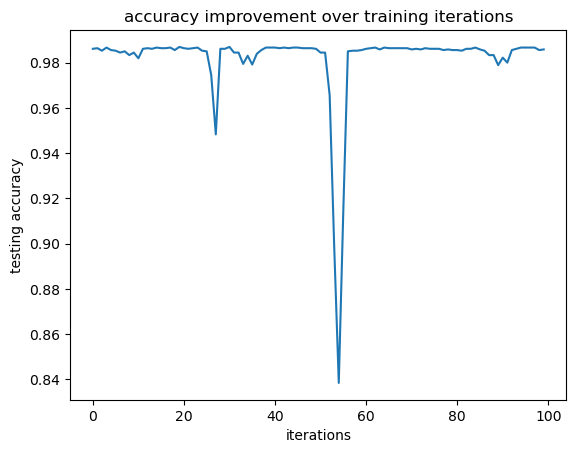

In [51]:
plt.title("accuracy improvement over training iterations")
plt.xlabel("iterations")
plt.ylabel("testing accuracy")
plt.plot(iters_list, accs)
plt.show()

In [28]:
labels_test.shape[0]
pos_imgs = 0
for i in range(labels_test.shape[0]):
    if labels_test[i] == 1:
        pos_imgs += 1
print(pos_imgs / labels_test.shape[0])

0.16657397107897665


In [1]:
'Image filename : "Train/pos/crop001651.png"'.split(':')[1].strip().replace('"', '').strip()

'Train/pos/crop001651.png'